# MATH50003 Numerical Analysis: Problem Sheet 4

This problem sheet explores least squares, the QR decomposition including for
tridiagonal matrices,
and the PLU decompositions.

Questions marked with a ⋆ are meant to be completed without using a computer.

In [3]:
using LinearAlgebra, Plots

## 1. Least squares and QR decompositions

**Problem 1.1** Find and plot the best least squares fit of ${1 \over 5x^2 + 1}$ by degree $n$
polynomials for $n = 0,\ldots,10$ at 1000 evenly spaced points between $0$ and $1$.

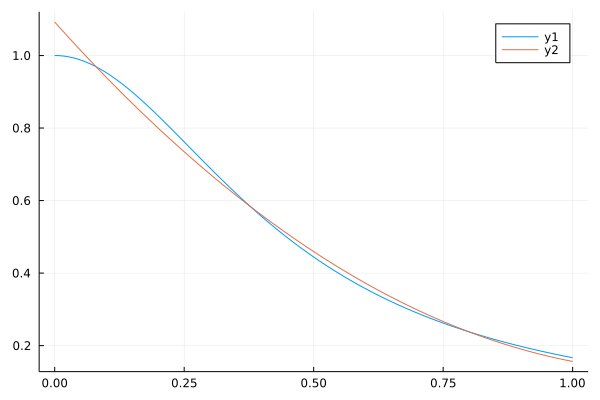

In [4]:
n = 2

x = collect(LinRange(0,1,1000))
f = 1 ./ (5*x.^2 .+ 1)
A = zeros(eltype(x),1000,n+1)
for i in 1:n+1
    A[:,i] = x .^(i-1)
end
Q,R = qr(A)
#(can just do standard 'solve system' and julia will automatically do QR)
p = A \ f 
#p = R \ (Q'*f)[1:size(R)[1],:]

plot(x,f)
plot!(x,A*p)


**Problem 1.2⋆** Show that every matrix has a QR decomposition such that the diagonal of $R$ is non-negative.
Make sure to include the case of more columns than rows.

**Problem 1.3⋆** Show that the QR decomposition of a square invertible matrix is unique, 
provided that the diagonal of $R$ is positive.


## 2. Gram–Schmidt

**Problem 2.1⋆** The modified Gram–Schmidt algorithm is a slight variation of Gram–Schmidt where
instead of computing
$$
𝐯_j := 𝐚_j - \sum_{k=1}^{j-1} \underbrace{𝐪_k^\top 𝐚_j}_{r_{kj}} 𝐪_k
$$
we compute it step-by-step:
$$
\begin{align*}
𝐯_j^1 &:= 𝐚_j \\
𝐯_j^{k+1} &:= 𝐯_j^k - 𝐪_k^\top 𝐯_j^k 𝐪_k
\end{align*}
$$
Show that $𝐯_j^j = 𝐯_j$. 

**Problem 2.2** Complete the following
function implementing the modified Gram–Schmidt algorithm:

In [5]:
function modifiedgramschmidt(A)
    m,n = size(A)
    m ≥ n || error("Not supported")
    R = zeros(n,n)
    Q = zeros(m,n)
    for j = 1:n
        # TODO: Implement the Modified Gram–Schmidt algorthm
        v = A[:,j]
        for k = 1:j-1
            R[k,j] = dot(Q[:,k],v)
            v = v - R[k,j]*Q[:,k]
        end
        R[j,j] = norm(v)
        Q[:,j] = v/norm(v)
    end
    Q,R
end

modifiedgramschmidt (generic function with 1 method)

In [7]:
#(2.3) Don't know how to do normal gram schmidt

function gramschmidt(A)
    m,n = size(A)
    m ≥ n || error("Not supported")
    R = zeros(n,n)
    Q = zeros(m,n)
    for j = 1:n
        for k = 1:j-1
            R[k,j] = Q[:,k]'*A[:,j]
        end
        v = A[:,j] - Q[:,1:j-1]*R[1:j-1,j]
        R[j,j] = norm(v)
        Q[:,j] = v/R[j,j]
    end
    Q,R
end
    

A = randn(300,300)
Q, R = gramschmidt(A)
Qm, Rm = modifiedgramschmidt(A)
norm(Q'Q - I), norm(Qm'Qm - I)

(4.151068333108232e-12, 6.925426498814387e-13)

**Problem 2.3** Compare the orthogonality of `Q` between `gramschmidt` and `modifiedgramschmidt`
when applied to a `300 × 300` random matrix.

## 3. Householder reflections


**Problem 3.1**
Complete the definition of `Reflections` which supports a sequence of reflections,
that is, 
$$
Q = Q_{𝐯_1} \cdots Q_{𝐯_n}
$$
where the vectors are stored as a matrix `V` whose $j$-th column is $𝐯_j$, and
$$
Q_{𝐯_j} = I - 2 𝐯_j 𝐯_j^\top
$$

In [8]:
struct Reflections{T} <: AbstractMatrix{T}
    V::Matrix{T}
end

import Base: *, size, getindex

size(Q::Reflections) = (size(Q.v,1), size(Q.v,1))


function *(Q::Reflections, x::AbstractVector)
    # TODO: Apply Q in O(mn) operations
    n,m = size(Q.v)
    for j = m:-1:1
        x = x - 2*Q.v[:,j]*Q.v[:,j]'
    end
    x
end

function getindex(Q::Reflections, k::Int, j::Int)
    # TODO: Return Q[k,j] in O(mn) operations (hint: use *)
    ej = zeros(eltype(Q),size(Q.v,1))
    ej[j] += 1
    ek = zeros(eltype(Q),size(Q.v,1))
    ek[k] += 1
    ek'*Q*ej
end

getindex (generic function with 325 methods)

**Problem 3.2** Complete the following function that implements
 Householder QR using only $O(mn^2)$ operations:

In [12]:
function householderqr(A)
    m,n = size(A)
    R = copy(A)
    Q = Reflections(Matrix(1.0I, m, n))
    for j = 1:min(m,n) #loop ofr however many reflections needed
        # TODO: populate Q and R using O(m*(n-j)) operations
        # take jth col of R, starting with jth entry, form householder vector
        y = copy(R[j:end,j])
        y[1] += ((y[1] ≥ 0) ? 1 : -1)*norm(y)
        w = y/norm(y)
        #add vector to V
        Q.v[j:end,j] = w
        #apply this reflection to R (only need to apply to the rows we calculate with)
        R[j:end,:] = R[j:end,:] - 2*w*w'*R[j:end,:]
    end
    Q,R
end

householderqr (generic function with 1 method)

## 4. Banded QR with Given's rotations

**Problem 4.1⋆**  Describe an algorithm for computing the QR decomposition
of a tridiagonal matrix using rotations instead of reflections to upper-triangularise
column-by-column.

**Problem 4.2** Implement `Rotations` which represents an orthogonal matrix `Q` that is a product
 of rotations of angle `θ[k]`, each acting on the entries `k:k+1`.

In [6]:
struct Rotations{T} <: AbstractMatrix{T}
    θ::Vector{T}
end

import Base: *, size, getindex

size(Q::Rotations) = (length(Q.θ)+1, length(Q.θ)+1)


function *(Q::Rotations, x::AbstractVector)
    # TODO: Apply Q in O(n) operations
end

function getindex(Q::Rotations, k::Int, j::Int)
    # TODO: Return Q[k,j] in O(n) operations (hint: use *)
end

getindex (generic function with 326 methods)

**Problem 4.3** Combine `Rotations` and `UpperTridiagonal` from last problem sheet
to implement a banded QR decomposition that only takes $O(n)$ operations:

In [7]:
function bandedqr(A::Tridiagonal)
    n = size(A,1)
    Q = Rotations(zeros(n-1)) # Assume Float64
    R = UpperTridiagonal(zeros(n), zeros(n-1), zeros(n-2))
    for j = 1:n-1
        # TODO: populate Q and R
    end
    Q,R
end

bandedqr (generic function with 1 method)

**Problem 4.4⋆** Could one redesign the above to only use IEEE operatations (addition, multiplication, square-roots, 
avoiding calls `atan`, `cos`, and `sin`)?
Would it have been possible to implement this algorithm using reflections?
If so, what would be the structure of a matrix whose columns are the vectors of reflections?

## 5. PLU decomposition

**Problem 5.1⋆** Compute the PLU decompositions for the following matrices:
$$
\begin{bmatrix}
0 & 2 & 1 \\
2 & 6 & 1 \\
1 & 1 & 4
\end{bmatrix},
\begin{bmatrix}
1 & 2 & -1 & 0 \\
2 & 4 & -2 & 1 \\
-3 & -5 & 6 & 1 \\
-1 & 2 & 8 & -2
\end{bmatrix}
$$